In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('training_dataset_1.csv')

In [4]:

# Example dataframe structure
# Ensure `obs` is sequentially numbered and there are exactly 300 rows for each observation
# Initialize list for storing reshaped data
observations = []
class_labels = np.zeros([1000, 1])

i = 0
# Group by 'label' and 'obs' to process each class label and its observations
for label, label_group in data.groupby('label'):
    for obs_id, group in label_group.groupby('obs'):
        # Ensure the group has exactly 300 rows
        if len(group) != 300:
            raise ValueError(f"Observation {obs_id} for label {label} does not have 300 rows.")

        # Extract x, y, z columns and convert to NumPy array
        xyz = group[['x', 'y', 'z']].to_numpy()
        # Shape: (300, 3)
        observations.append(xyz)
        class_labels[i] = label
        i+=1

# Stack all observations into a single NumPy array
final_array = np.stack(observations)
# Shape: (num_observations, 3, 300)

# Check final shape
# Expected shape: (1000, 3, 300)
print(final_array.shape)

# Verify the shape
# Expected output: (1000,)
print(class_labels.shape)



(1000, 300, 3)
(1000, 1)


In [5]:
# Assuming X is of shape (300, 3, numSamples) and Y is of shape (numSamples,)
# X and Y should be numpy arrays
X, Y = final_array, class_labels

# Parameters
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results
accuracies = []
conf_matrices = []
precision_list = []
recall_list = []
f1_scores_list = []

# Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(300, 3, 1)),

        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), name='maxpool'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    return model

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(X, Y)):
    print("Training fold...")

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Reshape for CNN
    X_train = X_train.reshape((X_train.shape[0], 300, 3, 1))
    X_test = X_test.reshape((X_test.shape[0], 300, 3, 1))

    Y_train = to_categorical(Y_train, num_classes=10)
    Y_test = to_categorical(Y_test, num_classes=10)

    # Create and compile the model
    model = create_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Train the model
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=8, batch_size=8, verbose=1)

    # Evaluate
    Y_pred = np.argmax(model.predict(X_test), axis=1)
    Y_pred = to_categorical(Y_pred, num_classes=10)
    accuracy = np.mean(Y_pred == Y_test)
    accuracies.append(accuracy)

    # Confusion matrix
    conf_mat = confusion_matrix(Y_test, Y_pred)
    conf_matrices.append(conf_mat)

#     # Precision, Recall, F1 score
#     precision = precision_score(Y_test, Y_pred, average=None)
#     recall = recall_score(Y_test, Y_pred, average=None)
#     f1 = f1_score(Y_test, Y_pred, average=None)

#     precision_list.append(precision)
#     recall_list.append(recall)
#     f1_scores_list.append(f1)


# # Calculate averages
# avg_accuracy = np.mean(accuracies)
# avg_conf_mat = np.sum(conf_matrices, axis=0)
# avg_precision = np.mean(precision_list, axis=0)
# avg_recall = np.mean(recall_list, axis=0)
# avg_f1_score = np.mean(f1_scores_list, axis=0)

# # Display results
# print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))
# print("Average Precision: ", avg_precision)
# print("Average Recall: ", avg_recall)
# print("Average F1 Score: ", avg_f1_score)

# # Confusion Matrix Plot
# disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_mat)
# disp.plot()
# plt.title("Confusion Matrix")
# plt.show()

# # Bar plots
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(avg_precision)), avg_precision, color='blue', alpha=0.7, label='Precision')
# plt.title("Precision for each class")
# plt.xlabel("Class")
# plt.ylabel("Precision")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.bar(range(len(avg_recall)), avg_recall, color='orange', alpha=0.7, label='Recall')
# plt.title("Recall for each class")
# plt.xlabel("Class")
# plt.ylabel("Recall")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.bar(range(len(avg_f1_score)), avg_f1_score, color='green', alpha=0.7, label='F1 Score')
# plt.title("F1 Score for each class")
# plt.xlabel("Class")
# plt.ylabel("F1 Score")
# plt.legend()
# plt.show()


Training fold...


2024-12-20 17:17:59.936362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-20 17:17:59.936391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-20 17:17:59.936397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-20 17:17:59.936890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 17:17:59.937272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/8


2024-12-20 17:18:01.705597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5104 - loss: 81.6967 - val_accuracy: 0.1100 - val_loss: 135.1089
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8700 - loss: 27.0009 - val_accuracy: 0.2300 - val_loss: 175.3820
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9144 - loss: 22.8806 - val_accuracy: 0.4000 - val_loss: 107.1324
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8553 - loss: 73.1621 - val_accuracy: 0.6650 - val_loss: 86.2906
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9413 - loss: 29.7687 - val_accuracy: 0.8650 - val_loss: 48.4381
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9214 - loss: 33.4266 - val_accuracy: 0.8600 - val_loss: 75.9456
Epoch 7/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9013 - loss: 59.2025 - val_accuracy: 0.9900 - val_loss: 3.3512
Epoch 8/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9472 - loss: 32.4695 - val_accu

In [16]:
# Confusion matrix
conf_mat = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
conf_matrices.append(conf_mat)

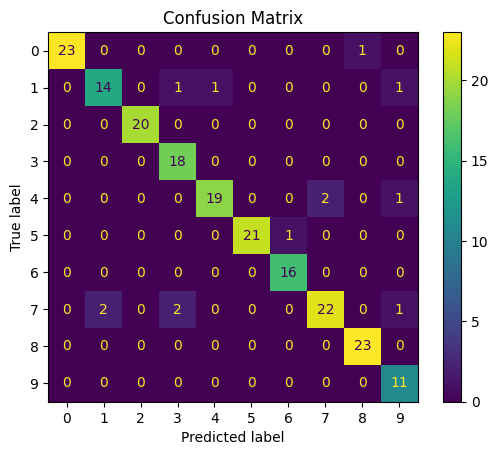

In [17]:
avg_conf_mat = np.sum(conf_matrices, axis=0)
# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()